# PyPSA-Zap Benchmarking Demo

This notebook demonstrates Zap's interoperability with PyPSA using the Texas 7-node network.

We cover:
1. **Dispatch Optimization** - Running economic dispatch in both Zap and PyPSA
2. **Investment Planning** - Capacity expansion optimization using Zap's gradient-based solver
3. **Comparative Visualization** - Energy balance, prices, and capacity comparisons

In [33]:
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt
from copy import deepcopy

# Set lower DPI for smaller figure file sizes in notebook
plt.rcParams['figure.dpi'] = 60
plt.rcParams['savefig.dpi'] = 60

import zap
from zap.importers.pypsa import load_pypsa_network, HOURS_PER_YEAR
from zap.devices.injector import Generator, Load
from zap.devices.transporter import ACLine
from zap.devices.storage_unit import StorageUnit
from zap.tests import network_examples as examples

# Import plotting helpers
from zap.tests.plotting_helpers import (
    get_zap_energy_balance,
    plot_energy_balance_comparison,
    plot_price_comparison,
    plot_capacity_comparison,
    plot_capacity_evolution,
    aggregate_capacities_by_carrier,
)

## 1. Load Texas 7-Node Network

In [34]:
# Configuration
NUM_SNAPSHOTS = 48  # Number of hours to simulate

# Load Texas 7-node network
pn = examples.load_example_network("texas_7node")
snapshots = pn.snapshots[:NUM_SNAPSHOTS]
pn.set_snapshots(snapshots)

# Set snapshot weightings to annualize operational costs
pn.snapshot_weightings.loc[:, :] = HOURS_PER_YEAR / len(snapshots)

#reduce the load by 40% to ensure feasible (since network is built for 2050 loads)
pn.loads_t.p_set *= 0.6


print(f"Network: Texas 7-node")
print(f"Snapshots: {len(snapshots)} hours")
print(f"Buses: {len(pn.buses)}")
print(f"Generators: {len(pn.generators)}")
print(f"Lines: {len(pn.lines)}")
print(f"Storage Units: {len(pn.storage_units)}")
pn

INFO:pypsa.io:Imported network texas_7node.nc has buses, carriers, generators, lines, loads, storage_units


Network: Texas 7-node
Snapshots: 48 hours
Buses: 7
Generators: 176
Lines: 12
Storage Units: 14


PyPSA Network
Components:
 - Bus: 7
 - Carrier: 17
 - Generator: 176
 - Line: 12
 - Load: 7
 - StorageUnit: 14
Snapshots: 48

In [35]:
# Import to Zap
net, devices = load_pypsa_network(pn, snapshots)
time_horizon = len(snapshots)

print(f"Zap network: {net.num_nodes} nodes")
print(f"Devices: {len(devices)}")
for i, dev in enumerate(devices):
    print(f"  [{i}] {type(dev).__name__}: {dev.num_devices} units")

INFO:zap.importers.pypsa:Importing Generator with 136 devices.
INFO:zap.importers.pypsa:Importing Load with 7 devices.
INFO:zap.importers.pypsa:Importing ACLine with 12 devices.
INFO:zap.importers.pypsa:Importing StorageUnit with 14 devices.


Zap network: 7 nodes
Devices: 4
  [0] Generator: 136 units
  [1] Load: 7 units
  [2] ACLine: 12 units
  [3] StorageUnit: 14 units


## 2. Dispatch Comparison: PyPSA vs Zap

First, let's compare the dispatch results (economic dispatch without capacity expansion).

In [36]:
# Run PyPSA optimization
pypsa_opt = pn.copy()

# Set extendable false for all generators to make problem dispatch-only
pypsa_opt.generators.p_nom_extendable = False
pypsa_opt.storage_units.p_nom_extendable = False
pypsa_opt.lines.s_nom_extendable = False

# Set investment periods to exclude retired plants (criteria build_year + lifetime >= 2050)
has_investment_periods = pypsa_opt.investment_periods.size > 0
pypsa_opt.optimize(solver_name="highs", multi_investment_periods=has_investment_periods)

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 5/5 [00:00<00:00, 168.19it/s]
INFO:linopy.io: Writing time: 0.27s
INFO:linopy.solvers:Log file at /private/var/folders/00/vqry7y9s78q3rvf_m_jmk_bc0000gn/T/highs.log
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 9120 primals, 26398 duals
Objective: 6.75e+09
Solver model: available
Solver message: optimal



Running HiGHS 1.12.0 (git hash: 755a8e0): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-ckhock56 has 26398 rows; 9120 cols; 44581 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 3e+02]
  Cost    [2e+03, 4e+04]
  Bound   [0e+00, 0e+00]
  RHS     [6e-01, 2e+04]
Presolving model
1054 rows, 3466 cols, 6150 nonzeros  0s
763 rows, 2903 cols, 5563 nonzeros  0s
Dependent equations search running on 716 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
763 rows, 2903 cols, 5563 nonzeros  0s
Presolve reductions: rows 763(-25635); columns 2903(-6217); nonzeros 5563(-39018) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
       1214     6.7530691950e+09 Pr: 0(0); Du: 0(4.14815e-11) 0s

Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : li

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Line-fix-s-lower, Line-fix-s-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, Kirchhoff-Voltage-Law, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

In [37]:
# Run Zap dispatch
dispatch = net.dispatch(devices, time_horizon=time_horizon, solver=cp.CLARABEL)

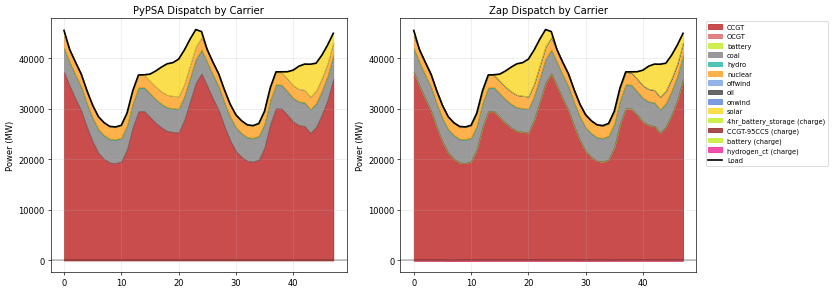

In [38]:
# Prepare energy balance data
hours = np.arange(time_horizon)

# PyPSA energy balance
pypsa_energy_raw = (
    pypsa_opt.statistics.energy_balance(
        comps=["Generator", "StorageUnit"],
        aggregate_time=False,
        nice_names=False,
    )
    .droplevel(0)
    .T
)
pypsa_energy = pypsa_energy_raw.T.groupby(level="carrier").sum().T
pypsa_energy.index = hours

# Zap energy balance
zap_energy = get_zap_energy_balance(devices, dispatch, pypsa_opt, time_horizon)

# Get carrier colors and load profile
carrier_colors = pypsa_opt.carriers.color.to_dict() if len(pypsa_opt.carriers) > 0 else {}
load_profile = pypsa_opt.loads_t.p_set.sum(axis=1).values if len(pypsa_opt.loads) > 0 else None

# Create comparison plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_energy_balance_comparison(
    axes[0], axes[1],
    pypsa_energy, zap_energy,
    carrier_colors, load_profile,
    title_left="PyPSA Dispatch by Carrier",
    title_right="Zap Dispatch by Carrier",
)
axes[1].legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=8)
plt.tight_layout()
plt.show()

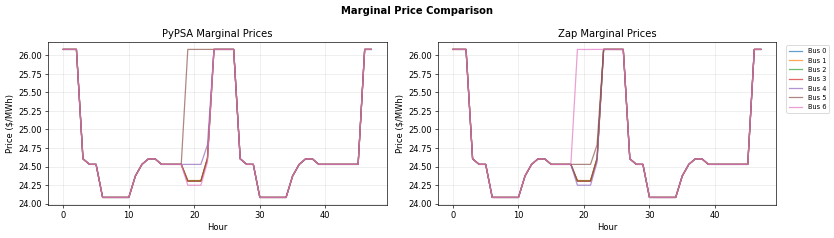

In [39]:
# Marginal price comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_price_comparison(
    axes[0], axes[1],
    pypsa_opt.buses_t.marginal_price,
    dispatch.prices,
    hours,
)
axes[1].legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=8)
plt.suptitle("Marginal Price Comparison", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.show()

## 3. Capacity Expansion Planning

Now let's set up and solve a capacity expansion problem using Zap's gradient-based planning.

In [40]:
# Define which parameters to optimize
parameter_names = {}
for device_idx, device in enumerate(devices):
    if isinstance(device, Generator):
        parameter_names["generator"] = (device_idx, "nominal_capacity")
    elif isinstance(device, ACLine):
        parameter_names["ac_line"] = (device_idx, "nominal_capacity")
    elif isinstance(device, StorageUnit):
        parameter_names["storage_unit"] = (device_idx, "power_capacity")

print("Parameters to optimize:")
for param_name, (idx, attr) in parameter_names.items():
    print(f"  {param_name}: device[{idx}].{attr}")

Parameters to optimize:
  generator: device[0].nominal_capacity
  ac_line: device[2].nominal_capacity
  storage_unit: device[3].power_capacity


In [41]:
# Create dispatch layer for planning
layer = zap.DispatchLayer(
    net,
    devices,
    parameter_names=parameter_names,
    time_horizon=time_horizon,
    solver=cp.CLARABEL,
    solver_kwargs={"verbose": False},
)

In [42]:
# Set up bounds for capacity expansion
lower_bounds = {}
upper_bounds = {}

for param_name, (device_idx, attr_name) in parameter_names.items():
    device = devices[device_idx]
    
    # Handle different device types
    if isinstance(device, StorageUnit):
        min_attr, max_attr = "min_power_capacity", "max_power_capacity"
    else:
        min_attr, max_attr = "min_nominal_capacity", "max_nominal_capacity"
    
    # Set lower bound
    if hasattr(device, min_attr) and getattr(device, min_attr) is not None:
        lower_bounds[param_name] = deepcopy(getattr(device, min_attr))
    else:
        lower_bounds[param_name] = np.zeros_like(getattr(device, attr_name))
    
    # Set upper bound (handle inf values)
    if hasattr(device, max_attr) and getattr(device, max_attr) is not None:
        max_cap = deepcopy(getattr(device, max_attr))
        if np.any(np.isinf(max_cap)):
            current_cap = getattr(device, attr_name)
            reasonable_upper = (current_cap + 1000.0) * 10.0
            max_cap = np.where(np.isinf(max_cap), reasonable_upper, max_cap)
        upper_bounds[param_name] = max_cap
    else:
        current_cap = getattr(device, attr_name)
        upper_bounds[param_name] = (current_cap + 1000.0) * 10.0

# Apply minimum capacity floors
min_capacity_floor = 0.1  # MW
for param_name in lower_bounds:
    lower_bounds[param_name] = np.maximum(lower_bounds[param_name], min_capacity_floor)

if "storage_unit" in lower_bounds:
    lower_bounds["storage_unit"] = np.maximum(lower_bounds["storage_unit"], 10.0)

print("Bounds configured successfully")

Bounds configured successfully


In [43]:
# Define objectives
op_objective = zap.planning.DispatchCostObjective(net, devices)
inv_objective = zap.planning.InvestmentObjective(devices, layer)

# Snapshot weight to annualize operational costs
snapshot_weight = HOURS_PER_YEAR / len(snapshots)

# Create planning problem
problem = zap.planning.PlanningProblem(
    operation_objective=op_objective,
    investment_objective=inv_objective,
    layer=layer,
    lower_bounds=lower_bounds,
    upper_bounds=upper_bounds,
    snapshot_weight=snapshot_weight,
)

print(f"Planning problem created")
print(f"Snapshot weight: {snapshot_weight:.2f} (annualizing {len(snapshots)} hours)")

Planning problem created
Snapshot weight: 182.50 (annualizing 48 hours)


In [44]:
# Initialize parameters at current values
initial_params = {}
for param_name, (device_idx, attr_name) in parameter_names.items():
    initial_params[param_name] = deepcopy(getattr(devices[device_idx], attr_name))

print("Initial parameters:")
for param_name, values in initial_params.items():
    print(f"  {param_name}: {values.shape}, sum={values.sum():.1f} MW")

Initial parameters:
  generator: (136, 1), sum=74730.5 MW
  ac_line: (12, 1), sum=64610.4 MW
  storage_unit: (14, 1), sum=7255.6 MW


## 4. Solve Planning Problem

Run gradient descent optimization with loss and parameter tracking.

In [45]:
from zap.planning.trackers import LOSS, GRAD_NORM, PROJ_GRAD_NORM, TIME, PARAM

# Optimization hyperparameters
NUM_ITERATIONS = 250
STEP_SIZE = 1e-1
CLIP = 1e4

# Solve planning problem
optimized_params, history = problem.solve(
    num_iterations=NUM_ITERATIONS,
    algorithm=zap.planning.GradientDescent(step_size=STEP_SIZE, clip=CLIP),
    initial_state=initial_params,
    trackers=[LOSS, GRAD_NORM, PROJ_GRAD_NORM, TIME, PARAM],
)

print(f"Optimization completed in {NUM_ITERATIONS} iterations")
print(f"Final loss: ${history['loss'][-1]:,.2f}")
print(f"Final grad norm: {history['grad_norm'][-1]:.6f}")

[0]
Starting iteration 1
[0]
Starting iteration 2
[0]
Starting iteration 3
[0]
Starting iteration 4
[0]
Starting iteration 5
[0]
Starting iteration 6
[0]
Starting iteration 7
[0]
Starting iteration 8
[0]
Starting iteration 9
[0]
Starting iteration 10
[0]
Starting iteration 11
[0]
Starting iteration 12
[0]
Starting iteration 13
[0]
Starting iteration 14
[0]
Starting iteration 15
[0]
Starting iteration 16
[0]
Starting iteration 17
[0]
Starting iteration 18
[0]
Starting iteration 19
[0]
Starting iteration 20
[0]
Starting iteration 21
[0]
Starting iteration 22
[0]
Starting iteration 23
[0]
Starting iteration 24
[0]
Starting iteration 25
[0]
Starting iteration 26
[0]
Starting iteration 27
[0]
Starting iteration 28
[0]
Starting iteration 29
[0]
Starting iteration 30
[0]
Starting iteration 31
[0]
Starting iteration 32
[0]
Starting iteration 33
[0]
Starting iteration 34
[0]
Starting iteration 35
[0]
Starting iteration 36
[0]
Starting iteration 37
[0]
Starting iteration 38
[0]
Starting iteratio

In [46]:
# Update devices with optimized parameters
for param_name, (device_idx, attr_name) in parameter_names.items():
    if param_name in optimized_params:
        new_capacity = optimized_params[param_name]
        if hasattr(new_capacity, "numpy"):
            new_capacity = new_capacity.numpy()
        setattr(devices[device_idx], attr_name, new_capacity)
        print(f"Updated {param_name}: sum={np.sum(new_capacity):.1f} MW")

# Run final dispatch with optimized parameters
final_dispatch = net.dispatch(devices, time_horizon=time_horizon, solver=cp.CLARABEL)
print(f"\nFinal dispatch objective: ${final_dispatch.problem.value:,.2f}")

Updated generator: sum=74696.0 MW
Updated ac_line: sum=64610.4 MW
Updated storage_unit: sum=1493.2 MW

Final dispatch objective: $25,599,766.85


In [47]:
# Solve pypsa network to compare
pypsa_opt = pn.copy()
# Set investment periods to exclude retired plants (criteria build_year + lifetime >= 2050)
has_investment_periods = pypsa_opt.investment_periods.size > 0
pypsa_opt.optimize(solver_name="highs", multi_investment_periods=has_investment_periods)

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 231.59it/s]
INFO:linopy.io: Writing time: 0.34s
INFO:linopy.solvers:Log file at /private/var/folders/00/vqry7y9s78q3rvf_m_jmk_bc0000gn/T/highs.log


Running HiGHS 1.12.0 (git hash: 755a8e0): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-jzczfk0n has 26605 rows; 9257 cols; 57135 nonzeros
Coefficient ranges:
  Matrix  [4e-04, 3e+02]
  Cost    [1e+00, 3e+05]
  Bound   [2e+09, 2e+09]
  RHS     [3e-03, 5e+05]
Presolving model
13643 rows, 8533 cols, 42900 nonzeros  0s
Dependent equations search running on 1193 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
13540 rows, 8111 cols, 42375 nonzeros  0s
Presolve reductions: rows 13540(-13065); columns 8111(-1146); nonzeros 42375(-14760) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -1.6887453224e+06 Ph1: 986(1796.75); Du: 657(1.68875e+06) 0s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 9257 primals, 26605 duals
Objective: 5.37e+09
Solver model: available
Solver message: optimal



       7333     5.3670705652e+09 Pr: 0(0); Du: 0(4.97096e-11) 1s
       7333     5.3670705652e+09 Pr: 0(0); Du: 0(4.97096e-11) 1s

Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : linopy-problem-jzczfk0n
Model status        : Optimal
Simplex   iterations: 7333
Objective value     :  5.3670705652e+09
P-D objective error :  6.2191470497e-16
HiGHS run time      :          0.68
Writing the solution to /private/var/folders/00/vqry7y9s78q3rvf_m_jmk_bc0000gn/T/linopy-solve-w21j03i3.sol


INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Generator-ext-p-ramp_limit_up, Generator-ext-p-ramp_limit_down, Line-fix-s-lower, Line-fix-s-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, Kirchhoff-Voltage-Law, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

## 5. Results Visualization

### 5.1 Optimization Convergence

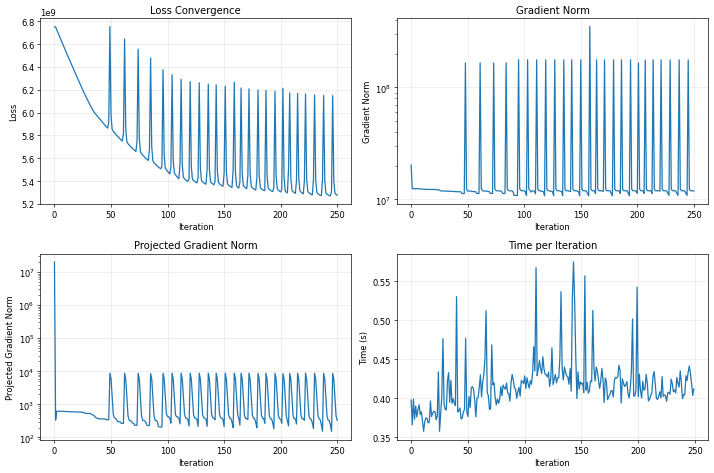

In [48]:
# Plot optimization convergence
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Loss
axes[0, 0].plot(history["loss"])
axes[0, 0].set_xlabel("Iteration")
axes[0, 0].set_ylabel("Loss")
axes[0, 0].set_title("Loss Convergence")
axes[0, 0].grid(True, alpha=0.3)

# Gradient norm
axes[0, 1].plot(history["grad_norm"])
axes[0, 1].set_xlabel("Iteration")
axes[0, 1].set_ylabel("Gradient Norm")
axes[0, 1].set_title("Gradient Norm")
axes[0, 1].set_yscale("log")
axes[0, 1].grid(True, alpha=0.3)

# Projected gradient norm
axes[1, 0].plot(history["proj_grad_norm"])
axes[1, 0].set_xlabel("Iteration")
axes[1, 0].set_ylabel("Projected Gradient Norm")
axes[1, 0].set_title("Projected Gradient Norm")
axes[1, 0].set_yscale("log")
axes[1, 0].grid(True, alpha=0.3)

# Time per iteration
axes[1, 1].plot(np.diff(history["time"]))
axes[1, 1].set_xlabel("Iteration")
axes[1, 1].set_ylabel("Time (s)")
axes[1, 1].set_title("Time per Iteration")
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 5.2 Capacity Comparison

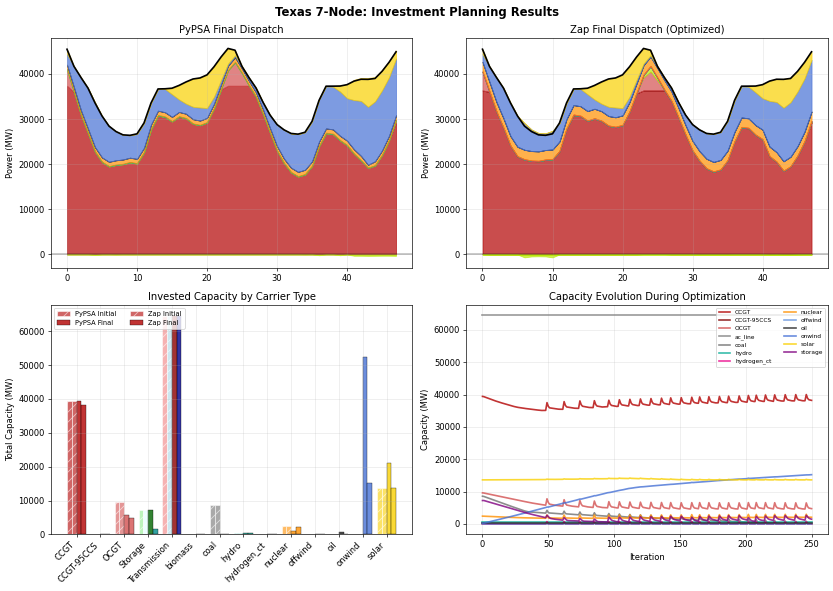

In [49]:
# Get final energy balance with optimized capacities
zap_final_energy = get_zap_energy_balance(devices, final_dispatch, pypsa_opt, time_horizon)


# PyPSA energy balance
pypsa_energy_raw = (
    pypsa_opt.statistics.energy_balance(
        comps=["Generator", "StorageUnit"],
        aggregate_time=False,
        nice_names=False,
    )
    .droplevel(0)
    .T
)
pypsa_energy = pypsa_energy_raw.T.groupby(level="carrier").sum().T
pypsa_energy.index = hours

# Aggregate capacities by carrier
pypsa_initial, pypsa_final, zap_initial, zap_final = aggregate_capacities_by_carrier(
    pypsa_opt, devices
)

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Top left: Final energy balance comparison
plot_energy_balance_comparison(
    axes[0, 0], axes[0, 1],
    pypsa_energy, zap_final_energy,
    carrier_colors, load_profile,
    title_left="PyPSA Final Dispatch",
    title_right="Zap Final Dispatch (Optimized)",
)

# Bottom left: Capacity comparison
plot_capacity_comparison(
    axes[1, 0],
    pypsa_initial, pypsa_final,
    zap_initial, zap_final,
    carrier_colors,
)

# Bottom right: Capacity evolution
plot_capacity_evolution(
    axes[1, 1],
    history,
    devices,
    pypsa_network=pypsa_opt,
    title="Capacity Evolution During Optimization",
)

plt.suptitle("Texas 7-Node: Investment Planning Results", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

### Note: we can see from our plots that our zap model has not converged fully! So we can expect some significant differences in the solutions.